In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

################################# 数据 读取-处理 开始#################################
sheet = pd.read_excel('data_input/乙二醇加权利润拟合残差_乙二醇总库存.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['MEG（含进口美金货）加权利润/7DMA拟合残差/乙二醇港口+聚酯工厂总库存'].last_valid_index()

sheet.head() 

,MEG（含进口美金货）加权利润/7DMA拟合残差/乙二醇港口+聚酯工厂总库存,WTI原油期货价格,秦皇岛动力煤价格取对数,乙二醇期货持仓量
Date,,,,
1991-08-20,NaN,21.40,NaN,NaN
1991-08-21,NaN,21.55,NaN,NaN
1991-08-22,NaN,21.72,NaN,NaN
1991-08-23,NaN,21.81,NaN,NaN
1991-08-26,NaN,21.97,NaN,NaN


In [4]:
sheet.columns  

Index(['MEG（含进口美金货）加权利润/7DMA拟合残差/乙二醇港口+聚酯工厂总库存', 'WTI原油期货价格', '秦皇岛动力煤价格取对数',
       '乙二醇期货持仓量'],
      dtype='object')

In [5]:

################################# 处理数据 让他们更适合 用来预测之后一个月的数据  #################################

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
# 所有数据截止到target_end
sheet = sheet[sheet.index <= target_end]


################################# 处理缺失值 #################################
fill_methods = {
    'WTI原油期货价格': 'interpolate', 
    '秦皇岛动力煤价格取对数': 'interpolate',
    '乙二醇期货持仓量': 'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
sheet.loc[:last_day, 'MEG（含进口美金货）加权利润/7DMA拟合残差/乙二醇港口+聚酯工厂总库存'] = sheet.loc[:last_day, 'MEG（含进口美金货）加权利润/7DMA拟合残差/乙二醇港口+聚酯工厂总库存'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['WTI原油期货价格_提前100天'] = sheet['WTI原油期货价格'].shift(100)
sheet['秦皇岛动力煤价格取对数_提前140天'] = sheet['秦皇岛动力煤价格取对数'].shift(140)
sheet['乙二醇期货持仓量_提前40天'] = sheet['乙二醇期货持仓量'].shift(40)

sheet['WTI原油期货价格_提前100天_逆序'] = reverse_column(sheet, 'WTI原油期货价格_提前100天')
sheet['秦皇岛动力煤价格取对数_提前140天_逆序'] = reverse_column(sheet, '秦皇岛动力煤价格取对数_提前140天')
sheet['乙二醇期货持仓量_提前40天_逆序'] = reverse_column(sheet, '乙二醇期货持仓量_提前40天')

################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2022-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['MEG（含进口美金货）加权利润/7DMA拟合残差/乙二醇港口+聚酯工厂总库存'].notna())
]

################################# 数据 读取-处理 结束 #################################

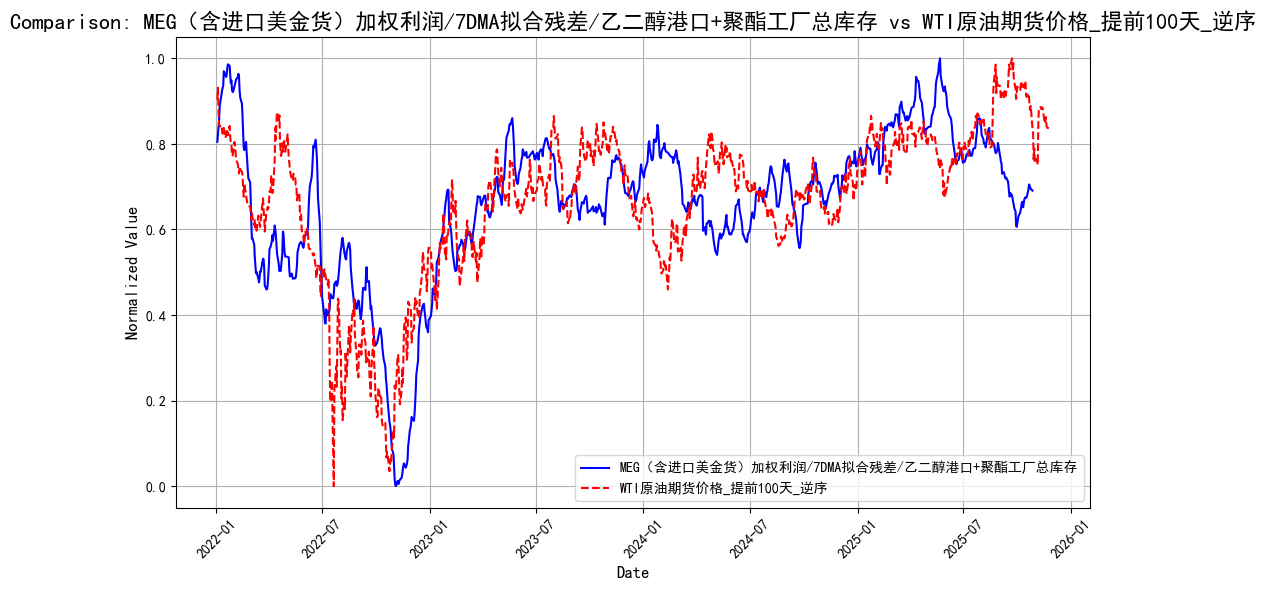

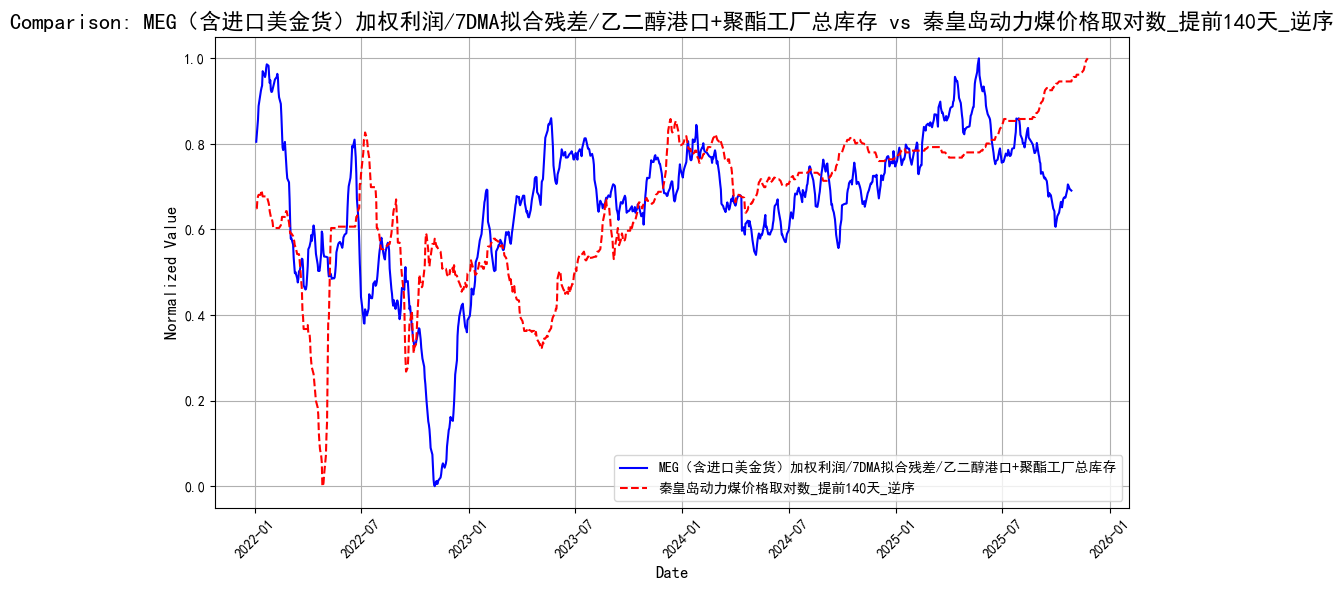

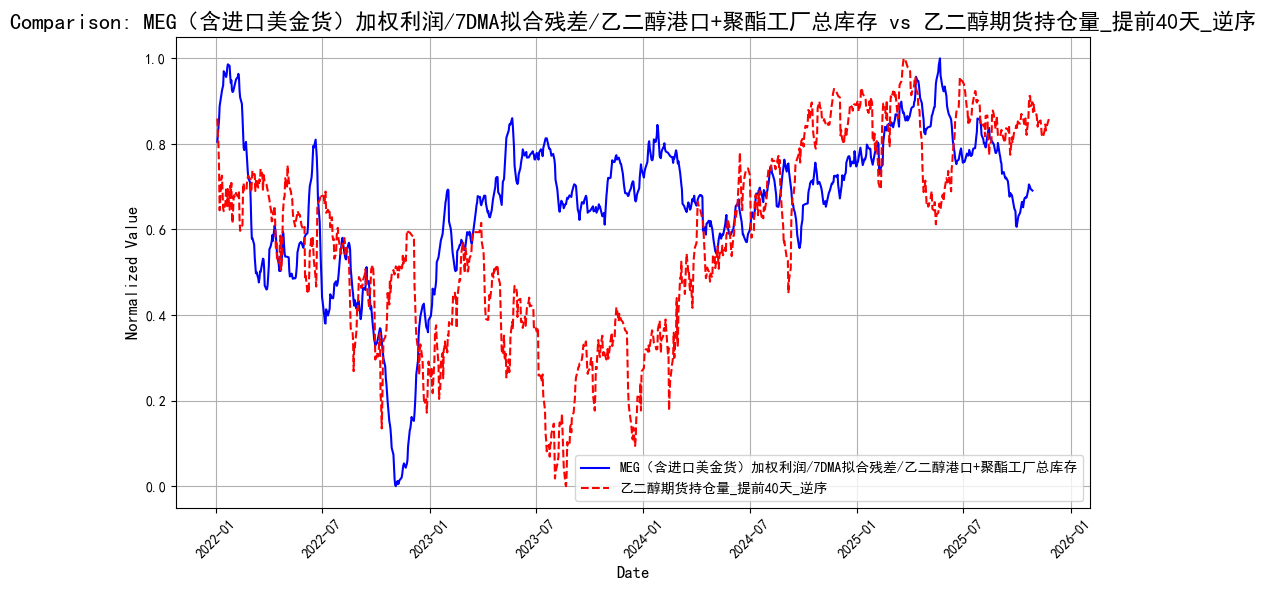

In [6]:
################################# X 和 Y 对比 观察领先性 #################################
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col= 'MEG（含进口美金货）加权利润/7DMA拟合残差/乙二醇港口+聚酯工厂总库存', 
    compare_cols=[
        'WTI原油期货价格_提前100天_逆序',
        '秦皇岛动力煤价格取对数_提前140天_逆序',
        '乙二醇期货持仓量_提前40天_逆序'
       ]
)

In [7]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 90
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        'WTI原油期货价格_提前100天_逆序',
        '秦皇岛动力煤价格取对数_提前140天_逆序',
        '乙二醇期货持仓量_提前40天_逆序'
]

predict_column = 'MEG（含进口美金货）加权利润/7DMA拟合残差/乙二醇港口+聚酯工厂总库存'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.05,  # 较小的学习率
    'max_depth': 4,  # 控制树的深度防止过拟合
    'min_child_weight': 8,  # 控制过拟合
    'subsample': 1,  # 随机采样防止过拟合
    'colsample_bytree': 1,  # 特征随机采样
    'gamma': 0.1,  # 控制分裂
    'reg_alpha': 0.1,  # L1正则化
    'reg_lambda': 1.0,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
}

num_boost_round = 10000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=300,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=300 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:123.71953	train-rmse:191.04538


[300]	eval-rmse:80.28573	train-rmse:45.03950


[600]	eval-rmse:85.18717	train-rmse:32.93756


[900]	eval-rmse:88.96942	train-rmse:28.23872


[1200]	eval-rmse:90.81276	train-rmse:24.90212


[1500]	eval-rmse:93.28630	train-rmse:22.10557


[1800]	eval-rmse:95.38580	train-rmse:19.98159


[2100]	eval-rmse:97.94820	train-rmse:18.30206


[2400]	eval-rmse:97.60076	train-rmse:16.82309


[2700]	eval-rmse:97.85775	train-rmse:15.39819


[3000]	eval-rmse:98.43929	train-rmse:14.07419


[3300]	eval-rmse:97.72200	train-rmse:12.93594


[3600]	eval-rmse:97.47782	train-rmse:11.90268


[3900]	eval-rmse:97.90269	train-rmse:11.09611


[4200]	eval-rmse:97.84224	train-rmse:10.35386


[4500]	eval-rmse:97.89911	train-rmse:9.67595


[4800]	eval-rmse:97.89725	train-rmse:9.01255


[5100]	eval-rmse:98.37918	train-rmse:8.41389


[5400]	eval-rmse:98.58373	train-rmse:7.92042


[5700]	eval-rmse:98.29112	train-rmse:7.47297


[6000]	eval-rmse:98.72794	train-rmse:7.01930


[6300]	eval-rmse:98.83064	train-rmse:6.60799


[6600]	eval-rmse:98.52315	train-rmse:6.20362


[6900]	eval-rmse:98.30290	train-rmse:5.85453


[7200]	eval-rmse:98.25193	train-rmse:5.57484


[7500]	eval-rmse:98.27591	train-rmse:5.28015


[7800]	eval-rmse:98.12304	train-rmse:5.01611


[8100]	eval-rmse:98.14819	train-rmse:4.76733


[8400]	eval-rmse:98.20769	train-rmse:4.57899


[8700]	eval-rmse:98.10367	train-rmse:4.35635


[9000]	eval-rmse:98.15749	train-rmse:4.15616


[9300]	eval-rmse:98.16609	train-rmse:3.93469


[9600]	eval-rmse:98.13626	train-rmse:3.77480


[9900]	eval-rmse:98.07778	train-rmse:3.61725


[9999]	eval-rmse:98.08003	train-rmse:3.56194


训练集 MSE (DMatrix): 14.0552, 训练集 R² (DMatrix): 0.9997
测试集 MSE (DMatrix): 9619.6915, 测试集 R² (DMatrix): -0.4093


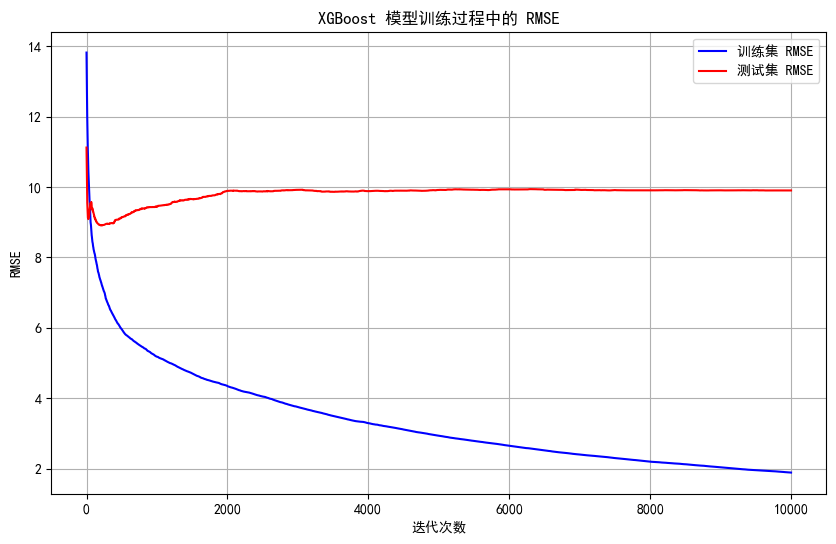

In [8]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)
all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重


# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=300,
    evals_result=evals_result,
    verbose_eval=300
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:185.38349


[300]	train-rmse:46.66119


[600]	train-rmse:35.18723


[900]	train-rmse:29.89207


[1200]	train-rmse:26.46675


[1500]	train-rmse:23.54208


[1800]	train-rmse:21.41596


[2100]	train-rmse:19.57794


[2400]	train-rmse:17.78406


[2700]	train-rmse:16.32307


[3000]	train-rmse:15.17923


[3300]	train-rmse:14.19584


[3600]	train-rmse:13.36477


[3900]	train-rmse:12.72383


[4200]	train-rmse:12.05335


[4500]	train-rmse:11.22579


[4800]	train-rmse:10.61844


[5100]	train-rmse:9.98825


[5400]	train-rmse:9.51756


[5700]	train-rmse:9.08158


[6000]	train-rmse:8.66937


[6300]	train-rmse:8.26835


[6600]	train-rmse:7.91752


[6900]	train-rmse:7.50788


[7200]	train-rmse:7.11878


[7500]	train-rmse:6.83585


[7800]	train-rmse:6.56273


[8100]	train-rmse:6.29593


[8400]	train-rmse:6.03755


[8700]	train-rmse:5.80112


[9000]	train-rmse:5.57156


[9300]	train-rmse:5.32839


[9600]	train-rmse:5.13492


[9900]	train-rmse:4.93904


[9999]	train-rmse:4.88508


全部数据 MSE: 26.4731, 全部数据 R²: 0.9994


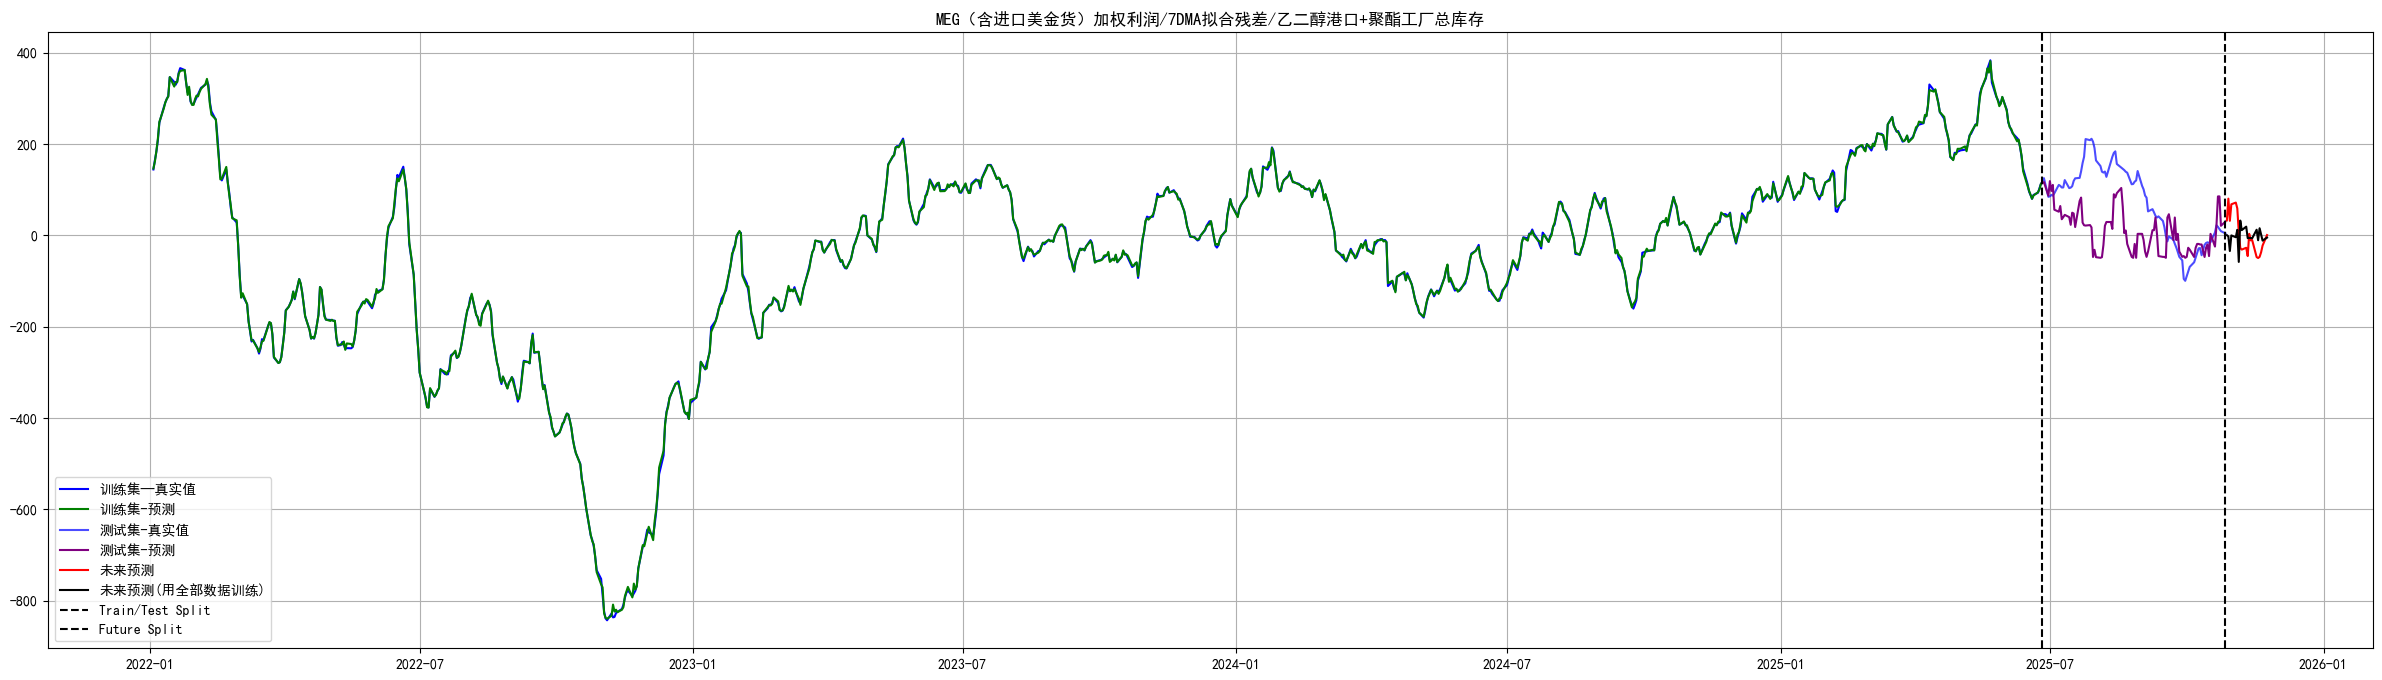

In [10]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('MEG（含进口美金货）加权利润/7DMA拟合残差/乙二醇港口+聚酯工厂总库存')
plt.legend()
plt.grid(True)
plt.show()

---

In [11]:
################################# 训练预测数据 excel格式输出  #################################

############ 日度 数据 ############
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})

historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})

merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/乙二醇加权利润残差拟合-总库存_合并数据.xlsx', index=False,float_format='%.4f')
merged_df_daily

,Date,真实值,预测值
772,2025/11/24,NaN,-5.285184
771,2025/11/21,NaN,-11.876700
770,2025/11/20,NaN,1.618539
769,2025/11/19,NaN,15.231463
768,2025/11/18,NaN,-11.014560
...,...,...,...
4,2023/01/09,-294.0576,NaN
3,2023/01/06,-277.0296,NaN
2,2023/01/05,-322.9629,NaN
1,2023/01/04,-338.0899,NaN


In [12]:
############ 月度 数据 ############
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
test_pred_2024 = test_data[['Date', '预测值']].copy()
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly.to_excel('eta/乙二醇加权利润残差拟合-总库存_月度数据.xlsx', index=False,float_format= '%.0f')
merged_df_monthly

,Date,真实值,预测值
34,2025/11/30,NaN,-0.887998
33,2025/10/31,-25.041720,-9.173676
32,2025/09/30,13.014004,-14.196192
31,2025/08/31,143.955805,8.963235
30,2025/07/31,133.799491,42.577065
29,2025/06/30,154.401129,153.394745
28,2025/05/31,275.499364,274.727905
27,2025/04/30,244.087791,244.274521
26,2025/03/31,215.576267,215.725143
25,2025/02/28,141.091204,140.426193


---

In [13]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.化工_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "MEG加权利润拟合残差/总库存"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [14]:
from Lcel import update_excel_data
file_path = "eta/1.化工_数据上传.xlsx"
sheet_name = "详情页"
identifier = "MEG加权利润拟合残差/总库存"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
